In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [3]:
# Data -------------------------------------------------------

# Read in data
df = pd.read_csv("jop_data.csv")

# Quick look at data
print(df.shape)
df.describe()
df.dtypes

(279837, 53)


Unnamed: 0                     int64
year                         float64
weight                       float64
age                          float64
race                          object
educ                          object
pid7                          object
black                        float64
hispanic                     float64
asian                        float64
mixedrace                    float64
married                      float64
foreignb                     float64
firstgen                     float64
unemp                        float64
ownhome                      float64
protestant                   float64
catholic                     float64
jewish                       float64
atheist                      float64
voteregpre                   float64
votegenval                   float64
voteprival                   float64
inputstate                   float64
state                         object
presidentialelectionyear     float64
senateelectionyear           float64
g

In [4]:
# Data pre-processing ----------------------------------------

# Glance at missing variables 
df.isnull().sum()

# Remove first column
df = df.drop(df.columns[0], axis=1)

# Filter rows where voteprival is NaN
df = df[df['voteprival'].notnull()]
print(df.shape)
df.head()

# Impute median for missing income values 
df['inc'] = df['inc'].fillna(df['inc'].median())

# Drop remaining missing values
df = df.dropna()

# Convert year to object variable
df['year'] = df.astype('object')

# One hot encoding for object variables
df = pd.get_dummies(df,prefix=['year', 'race', 'educ', 'pid7', 'state'])

# Get list of variable names
list(df.columns)

# Drop race_White, educ_No HS, pid7_Independent, state_Alabama
df = df.drop(columns=['race_White', 'educ_No HS', 'pid7_Independent',
                        'state_Alabama', 'year_2008.0'])

# Drop weight, votegenval, and pid3z columns
df = df.drop(columns = ['weight', 'votegenval', 'pid3z'])

(162461, 52)


In [39]:
# Get list of variable names
list(df.columns)

['year',
 'age',
 'black',
 'hispanic',
 'asian',
 'mixedrace',
 'married',
 'foreignb',
 'firstgen',
 'unemp',
 'ownhome',
 'protestant',
 'catholic',
 'jewish',
 'atheist',
 'voteregpre',
 'voteprival',
 'inputstate',
 'presidentialelectionyear',
 'senateelectionyear',
 'gubernatorialelectionyear',
 'days_before_election',
 'early_in_person',
 'vote_by_mail',
 'no_excuse_absence_',
 'male',
 'inc',
 'unionz',
 'childrenz',
 'white',
 'libconnew',
 'marginpnew',
 'newstrict',
 'y2006',
 'y2008',
 'y2010',
 'libcon3',
 'pid3z',
 'stricty',
 'hispstricty',
 'asianstricty',
 'blackstricty',
 'libconnewstricty',
 'pid7stricty',
 'mixedracestricty',
 'whitestricty',
 'race_Asian',
 'race_Black',
 'race_Hispanic',
 'race_Middle Eastern',
 'race_Mixed',
 'race_Native American',
 'race_Other',
 'educ_2-year',
 'educ_4-year',
 'educ_High school graduate',
 'educ_Post-grad',
 'educ_Some college',
 'pid7_Lean Democrat',
 'pid7_Lean Republican',
 'pid7_Not very strong Democrat',
 'pid7_Not very s

In [19]:
# Automl with h2o -----------------------------------------------

# Split data into test and train sets and save to file
train, test = train_test_split(df, test_size=0.2, random_state = 42)

# Initialize h2o
h2o.init()

In [6]:
# Convert pandas df to h2o df
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

# Set predictors and response
x = train.columns
y = "voteprival"
x.remove(y)

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
# Automl
aml = H2OAutoML(max_models=30, seed=21)

In [8]:
# Train models
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [9]:
# Glimpse at leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190904_204206,0.794029,0.54547,0.296107,0.429469,0.184443
StackedEnsemble_BestOfFamily_AutoML_20190904_204206,0.793392,0.545987,0.290716,0.429742,0.184678
XGBoost_1_AutoML_20190904_204206,0.792841,0.543258,0.294695,0.429281,0.184282
GBM_2_AutoML_20190904_204206,0.791454,0.54503,0.290711,0.430022,0.184919
XGBoost_2_AutoML_20190904_204206,0.790844,0.54543,0.29179,0.430296,0.185155
GBM_1_AutoML_20190904_204206,0.790185,0.546426,0.29285,0.430699,0.185501
XGBoost_3_AutoML_20190904_204206,0.788452,0.548629,0.291736,0.431768,0.186424
GLM_grid_1_AutoML_20190904_204206_model_1,0.777539,0.558899,0.306124,0.436616,0.190634


In [10]:
# Grab XGBoost Model
lb[:3,"model_id"]
m = h2o.get_model(lb[2,"model_id"])

In [11]:
# Evaluate results 
m.model_performance(test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18485645879588303
RMSE: 0.42994936771192377
LogLoss: 0.5447489232877654
Mean Per-Class Error: 0.2830728094276447
AUC: 0.7915817290309589
pr_auc: 0.7328160268205498
Gini: 0.5831634580619178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34553517283577667: 


,0,1,Error,Rate
0,8913.0,7783.0,0.4662,(7783.0/16696.0)
1,1757.0,11844.0,0.1292,(1757.0/13601.0)
Total,10670.0,19627.0,0.3149,(9540.0/30297.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3455352,0.7128927,256.0
max f2,0.1790278,0.8319242,328.0
max f0point5,0.5653638,0.6899487,154.0
max accuracy,0.5269267,0.7181569,172.0
max precision,0.9417091,1.0,0.0
max recall,0.0076460,1.0,399.0
max specificity,0.9417091,1.0,0.0
max absolute_mcc,0.4763990,0.4316819,196.0
max min_per_class_accuracy,0.4848354,0.7159200,192.0
max mean_per_class_accuracy,0.4763990,0.7169272,196.0


Gains/Lift Table: Avg response rate: 44.89 %, avg score: 45.07 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100010,0.8845526,2.0070066,2.0070066,0.9009901,0.9030258,0.9009901,0.9030258,0.0200721,0.0200721,100.7006619,100.7006619
,2,0.0200020,0.8644358,1.9481932,1.9775999,0.8745875,0.8741153,0.8877888,0.8885706,0.0194839,0.0395559,94.8193239,97.7599929
,3,0.0300030,0.8490124,1.9555449,1.9702483,0.8778878,0.8564554,0.8844884,0.8778655,0.0195574,0.0591133,95.5544911,97.0248256
,4,0.0400040,0.8358348,1.8820282,1.9481932,0.8448845,0.8426276,0.8745875,0.8690560,0.0188221,0.0779354,88.2028185,94.8193239
,5,0.0500050,0.8244312,1.8452698,1.9276086,0.8283828,0.8300497,0.8653465,0.8612548,0.0184545,0.0963900,84.5269822,92.7608555
,6,0.1000099,0.7731611,1.7658718,1.8467402,0.7927393,0.7977994,0.8290429,0.8295271,0.0883023,0.1846923,76.5871758,84.6740157
,7,0.1500149,0.7303738,1.7055880,1.7996895,0.7656766,0.7512832,0.8079208,0.8034458,0.0852878,0.2699801,70.5588043,79.9689452
,8,0.2000198,0.6926462,1.6011943,1.7500657,0.7188119,0.7105787,0.7856436,0.7802290,0.0800676,0.3500478,60.1194292,75.0065662
,9,0.2999967,0.6172493,1.4818511,1.6606805,0.6652361,0.6544682,0.7455166,0.7383180,0.1481509,0.4981987,48.1851088,66.0680477
,10,0.4000066,0.5437547,1.3085977,1.5726525,0.5874587,0.5808309,0.7059988,0.6989429,0.1308727,0.6290714,30.8597723,57.2652526


In [12]:
# Variable importance 
m.varimp(use_pandas = True)

,variable,relative_importance,scaled_importance,percentage
0,age,71521.257812,1.000000,0.225575
1,voteregpre,31822.490234,0.444938,0.100367
2,inc,17314.996094,0.242096,0.054611
3,inputstate,15695.923828,0.219458,0.049504
4,y2008,13615.395508,0.190369,0.042942
5,libconnew,12216.559570,0.170810,0.038531
6,marginpnew,11309.160156,0.158123,0.035669
7,pid7_StrongRepublican,10139.748047,0.141773,0.031980
8,pid7_StrongDemocrat,7585.418945,0.106058,0.023924
9,days_before_election,7270.787598,0.101659,0.022932


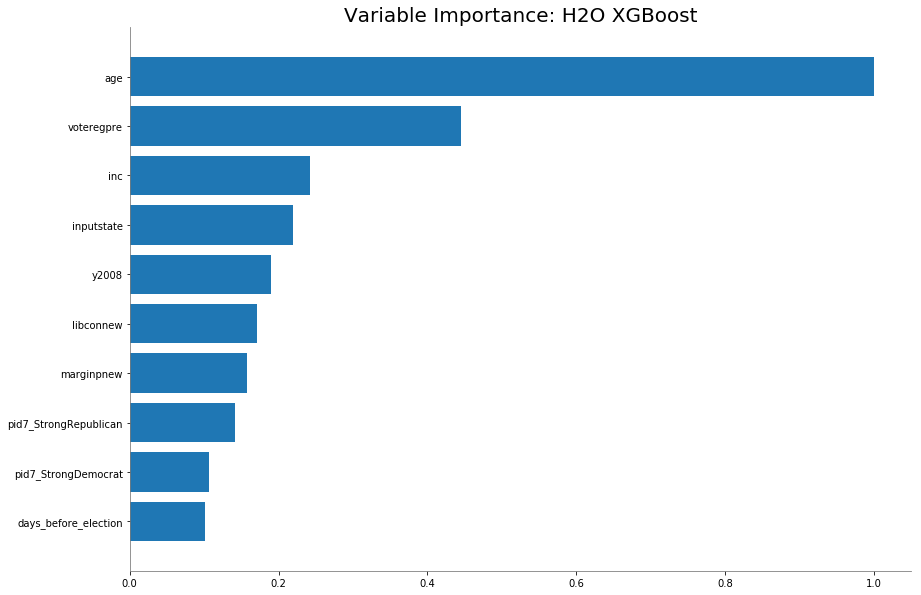

In [13]:
# Variable importance plot 
m.varimp_plot()

In [14]:
# Save preferred model and metrics 
h2o.save_model(model=m, force=True)

'/Users/andrew/Documents/Data_science_practice/Predicting_primary_voting/XGBoost_1_AutoML_20190904_204206'